# 测试集批量预测

## 进入MMSegmentation主目录

In [4]:
import os
os.chdir('mmsegmentation')

FileNotFoundError: [Errno 2] No such file or directory: 'mmsegmentation'

In [5]:
os.getcwd()

'/home/featurize/work/mmseg/mmsegmentation'

## 导入工具包

In [6]:
import os
import numpy as np
import cv2
from tqdm import tqdm
from osgeo import gdal

from mmseg.apis import init_model, inference_model, show_result_pyplot
import mmcv

import matplotlib.pyplot as plt
%matplotlib inline

## 载入模型

In [7]:
# 模型 config 配置文件
config_file = 'train_configs/UrbanVillageDataset_DataDecisionSegformer.py'

# 模型 checkpoint 权重文件
checkpoint_file = 'checkpoint/UrbanVillageDataset_DataDecisionSegformer.pth'

# 计算硬件
# device = 'cpu'
device = 'cuda:0'

In [8]:
model = init_model(config_file, checkpoint_file, device=device)

/home/featurize/work/mmseg/mmsegmentation/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/home/featurize/work/mmseg/mmsegmentation/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/home/featurize/work/mmseg/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:236: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  'Default ``avg_non_ignore`` is False, if you would like to '


Loads checkpoint by local backend from path: checkpoint/BeijingDataset_Segformer.pth


## 指定各个类别的配色方案

In [9]:
# 每个类别的 BGR 配色
palette = [
    ['Background', [127,127,127]],
    ['UrbanVillage', [0,0,200]]
]

palette_dict = {}
for idx, each in enumerate(palette):
    palette_dict[idx] = each[1]

In [10]:
palette_dict

{0: [127, 127, 127], 1: [0, 0, 200]}

## 创建空文件夹，存放测试集预测结果

In [11]:
# if not os.path.exists('outputs/testset-pred'):
#     os.mkdir('outputs/testset-pred')

if not os.path.exists('outputs/beijing'):
    os.mkdir('outputs/beijing')
    os.mkdir('outputs/beijing/testset-pred')

## 指定测试集路径（也可改成待测图像文件夹路径）

In [14]:
PATH_IMAGE = 'CitiesDataset/beijing/img/test'

In [15]:
os.chdir(PATH_IMAGE)

## 单张图像预测函数

In [16]:
opacity = 0.3 # 透明度，越大越接近原图

In [17]:
def process_single_img(img_path, save=False):
    
    img_bgr = cv2.imread(img_path)

    # 语义分割预测
    result = inference_model(model, img_bgr)
    pred_mask = result.pred_sem_seg.data[0].cpu().numpy()

    # 将预测的整数ID，映射为对应类别的颜色
    pred_mask_bgr = np.zeros((pred_mask.shape[0], pred_mask.shape[1], 3))
    for idx in palette_dict.keys():
        pred_mask_bgr[np.where(pred_mask==idx)] = palette_dict[idx]
    pred_mask_bgr = pred_mask_bgr.astype('uint8')

    # 将语义分割预测图和原图叠加显示
    pred_viz = cv2.addWeighted(img_bgr, opacity, pred_mask_bgr, 1-opacity, 0)
    
    # 保存图像至 outputs/testset-pred 目录
    if save:
        save_path = os.path.join('../', '../','../','../','outputs', 'beijing', 'testset-pred', 'pred-'+img_path.split('/')[-1])
        cv2.imwrite(save_path, pred_viz)
        
        save_path_mask = os.path.join('outputs', 'beijing', 'pred-mask', 'mask-'+img_path.split('/')[-1])
        save_pred_mask(pred_mask, save_path_mask)

    # 获取地理信息参数
        geotransform, spatial_ref = get_geo_info(img_path)
        save_path_mask = os.path.join('outputs', 'beijing', 'pred-mask', 'mask-'+img_path.split('/')[-1])
        save_pred_mask(pred_mask, save_path_mask, geotransform, spatial_ref)

def get_geo_info(img_path):
    dataset = gdal.Open(img_path)
    geotransform = dataset.GetGeoTransform()
    spatial_ref = dataset.GetProjection()
    return geotransform, spatial_ref

def save_pred_mask(pred_mask, save_path, geotransform, spatial_ref):
    # 获取预测mask的大小和类型
    rows, cols = pred_mask.shape
    driver = gdal.GetDriverByName("GTiff")
    # 创建tif文件
    outdata = driver.Create(save_path, cols, rows, 1, gdal.GDT_Byte)
    # 写入数据
    outdata.GetRasterBand(1).WriteArray(pred_mask)
    # 设置地理转换参数
    outdata.SetGeoTransform(geotransform)
    # 设置投影
    outdata.SetProjection(spatial_ref)
    # 关闭文件
    outdata = None

## 测试集批量预测

In [18]:
for each in tqdm(os.listdir()):
    process_single_img(each, save=True)

100%|██████████| 64/64 [00:26<00:00,  2.43it/s]


预测结果保存在 `mmsegmentation/outputs/testset-pred` 目录下

In [19]:
os.chdir(os.path.join('../','../','../', '../'))

## 删除系统自动生成的多余文件

### 查看待删除的多余文件

In [16]:
!find . -iname '__MACOSX'

In [17]:
!find . -iname '.DS_Store'

In [18]:
!find . -iname '.ipynb_checkpoints'

./configs/_base_/datasets/.ipynb_checkpoints
./mmseg/datasets/.ipynb_checkpoints
./checkpoint/.ipynb_checkpoints
./outputs/testset-pred/.ipynb_checkpoints


### 删除多余文件

In [19]:
!for i in `find . -iname '__MACOSX'`; do rm -rf $i;done

In [20]:
!for i in `find . -iname '.DS_Store'`; do rm -rf $i;done

In [21]:
!for i in `find . -iname '.ipynb_checkpoints'`; do rm -rf $i;done

### 验证多余文件已删除

In [22]:
!find . -iname '__MACOSX'

In [23]:
!find . -iname '.DS_Store'

In [24]:
!find . -iname '.ipynb_checkpoints'

## 测试集批量预测结果可视化

In [25]:
os.chdir('outputs/testset-pred')

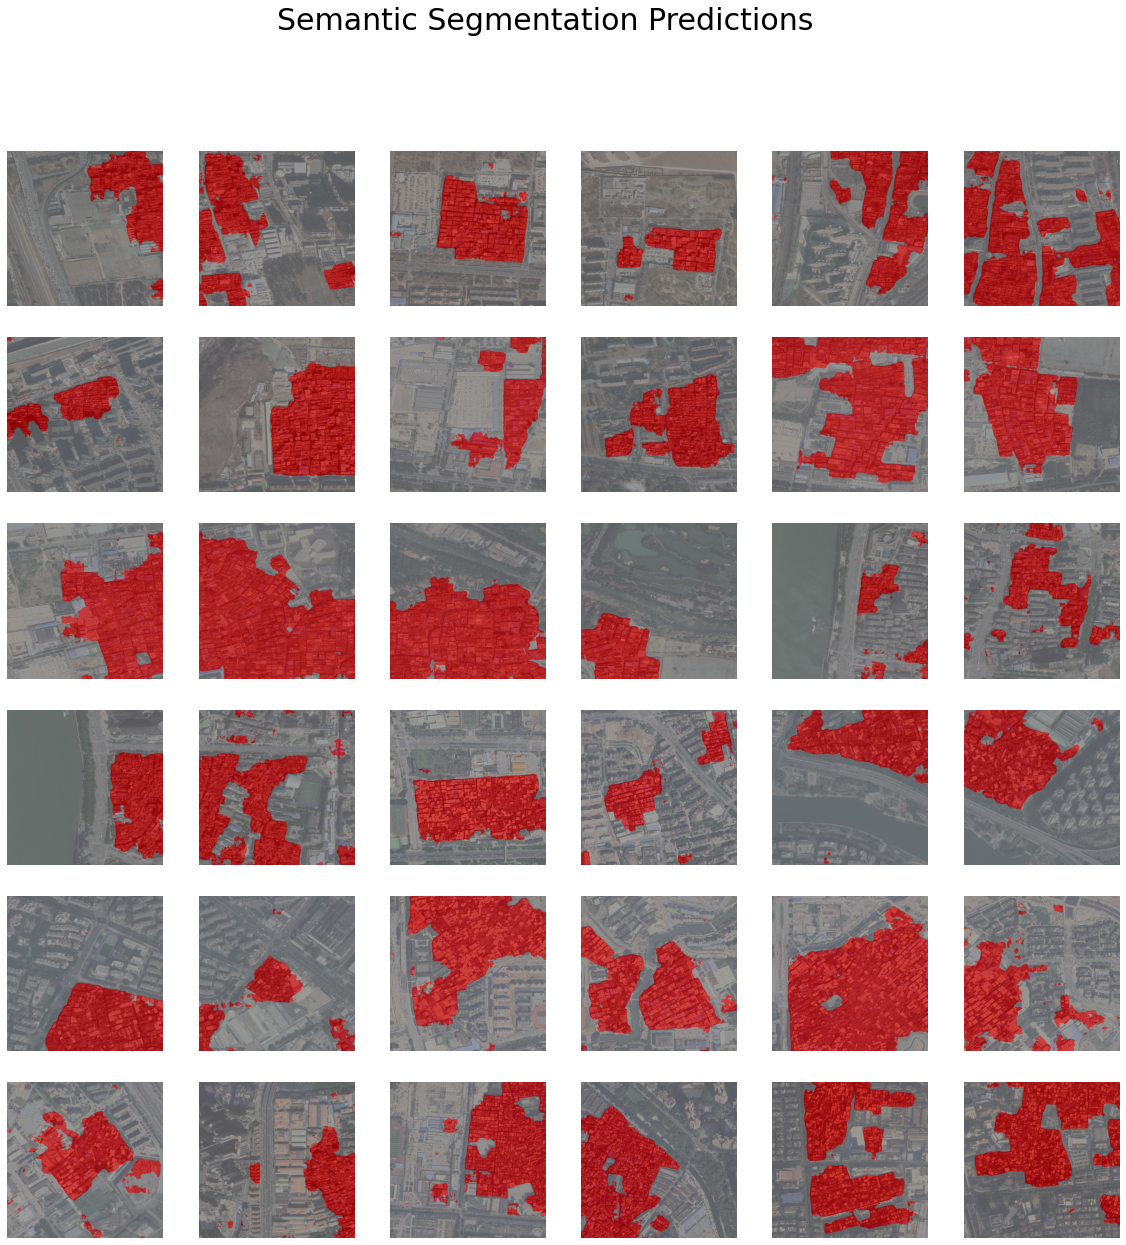

In [27]:
# n 行 n 列可视化
n = 6

fig, axes = plt.subplots(nrows=n, ncols=n, figsize=(20, 20))

for i, file_name in enumerate(os.listdir()[:n**2]):
    
    img_bgr = cv2.imread(file_name)
    
    # 可视化
    axes[i//n, i%n].imshow(img_bgr[:,:,::-1])
    axes[i//n, i%n].axis('off') # 关闭坐标轴显示
fig.suptitle('Semantic Segmentation Predictions', fontsize=30)
# plt.tight_layout()
plt.savefig('../K3.jpg')
plt.show()

## 注意：用于预测的图片，不能是训练集中的图片